# Script to extract SRTM elevations over study sites through Google Earth Engine (GEE)

Adapted from [2022 ICESat Hackweek notebook](https://github.com/ICESAT-2HackWeek/website2022/blob/main/book/tutorials/DataVisualization/Visualization_Earth_Engine_geemap_IS2_HW_2022.ipynb)

In [1]:
import os
import ee
import pandas as pd
import geopandas as gpd
import geemap
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import h5py
from rasterio import plot, warp

In [2]:
# -----GEE Authentication and Initialization
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

### AOI #1: Grand Mesa, CO

In [3]:
# -----Create geojson AOI
# used geojson.io
AOI1 = ee.Geometry({
        "type": "Polygon",
        "coordinates": [
          [
            [
              -108.24005126953124,
              38.884619201291905
            ],
            [
              -107.9,
              38.884619201291905
            ],
            [
              -107.9,
              39.11727568585598
            ],
            [
              -108.24005126953124,
              39.11727568585598
            ],
            [
              -108.24005126953124,
              38.884619201291905
            ]
          ]
        ]
      })

# -----Query for SRTM clip to AOI
SRTM1 = ee.Image("USGS/SRTMGL1_003").clip(AOI1)

# -----Plot elevations
# from: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
SRTM1_url = SRTM1.getThumbUrl({
    'min': 1000, 'max': 5000,
    'palette': ['white', 'green']})
Image(url=SRTM1_url)

### AOI #2: Mores Creek Summit, ID

In [4]:
# -----Create geojson AOI
# used geojson.io
AOI2 = ee.Geometry({
        "type": "Polygon",
        "coordinates": [
          [
            [
              -115.74131011962889,
              43.8855215890078
            ],
            [
              -115.61874389648438,
              43.8855215890078
            ],
            [
              -115.61874389648438,
              43.963661859597536
            ],
            [
              -115.74131011962889,
              43.963661859597536
            ],
            [
              -115.74131011962889,
              43.8855215890078
            ]
          ]
        ]
      })

# -----Query for SRTM clip to AOI
SRTM2 = ee.Image("USGS/SRTMGL1_003").clip(AOI2)

# -----Plot elevations
# from: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
SRTM2_url = SRTM2.getThumbUrl({
    'min': 1000, 'max': 5000,
    'palette': ['white', 'green']})
Image(url=SRTM2_url)

In [85]:
# -----Sample data along ICESat-2 tracks
# Load some ICESat-2 data, for now we load one track, one beam (GT2R/L)
data_path = '/home/jovyan/data/'
is2_file = 'processed_ATL08_20200920013522_13240806_005_01.h5' # Sept = snow-off 

with h5py.File(data_path+is2_file, 'r') as f:
    is2_gt2l = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                 'lon': f['gt2l/land_segments/longitude'][:],
                                  'h_te_best_fit': f['gt2l/land_segments/terrain/h_te_best_fit'][:]})

# select one of the beams and convert it to a geodataframe
is2_gdf = gpd.GeoDataFrame(is2_gt2l, geometry=gpd.points_from_xy(is2_gt2l.lon, is2_gt2l.lat), crs='epsg:7661')
is2_gdf.head()


,lat,lon,h_te_best_fit,geometry
0,43.937279,-115.664154,1867.905884,POINT (-115.66415 43.93728)
1,43.936382,-115.664284,1824.602539,POINT (-115.66428 43.93638)
2,43.935486,-115.664406,1801.802979,POINT (-115.66441 43.93549)
3,43.934586,-115.664528,1810.246460,POINT (-115.66453 43.93459)
4,43.933689,-115.664642,1814.206665,POINT (-115.66464 43.93369)


In [81]:
# -----function to convert pandas GeoDataFrame to ee.FeatureCollection
from functools import reduce
def feature2ee(gdf):

    g = [i for i in gdf.geometry]
    features=[]
    #for Point geo data type
    if (gdf.geom_type[0] == 'Point'):
        for i in range(len(g)):
            g = [i for i in gdf.geometry]
            x,y = g[i].coords.xy
            cords = np.dstack((x,y)).tolist()
            double_list = reduce(lambda x,y: x+y, cords)
            single_list = reduce(lambda x,y: x+y, double_list)
               
            g=ee.Geometry.Point(single_list)
            feature = ee.Feature(g)
            features.append(feature)

        ee_object = ee.FeatureCollection(features)
        return ee_object
        
# convert SRTM ee.Image to pd.DataFrame
is2_ee = feature2ee(is2_gdf)
is2_ee.getInfo();

In [84]:
# -----sample SRTM at points
SRTM2_sample = ee.FeatureCollection(SRTM2.sample(is2_ee))
SRTM2_sample_gdf = geemap.ee_to_geopandas(SRTM2_sample, selectors=['elevation'])
SRTM2_sample_gdf['lon'] = is2_gdf['lon']
SRTM2_sample_gdf['lat'] = is2_gdf['lat']
SRTM2_sample_gdf

,geometry,elevation,lon,lat
0,None,1882,-115.664154,43.937279
1,None,1848,-115.664284,43.936382
2,None,1833,-115.664406,43.935486
3,None,1839,-115.664528,43.934586
4,None,1846,-115.664642,43.933689
5,None,1857,-115.664749,43.932793
6,None,1887,-115.664856,43.931892
7,None,1895,-115.664970,43.930996
8,None,1930,-115.665070,43.930096
9,None,1947,-115.665184,43.929199


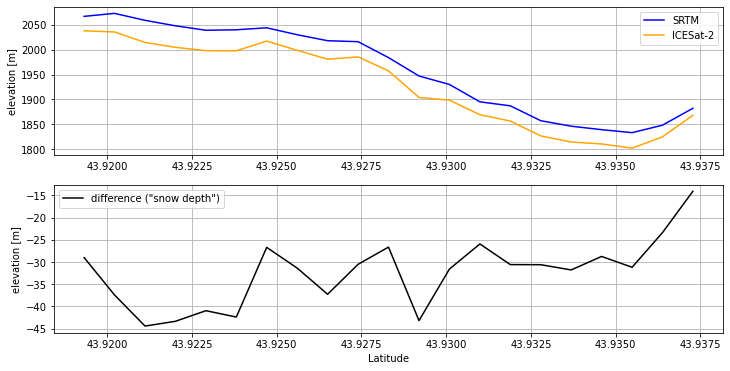

figure saved to file


In [106]:
# -----plot elevations
# SRTM sampled
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(SRTM2_sample_gdf['lat'], 
         SRTM2_sample_gdf['elevation'], color='blue', label='SRTM')
ax1.plot(SRTM2_sample_gdf['lat'],
         is2_gdf['h_te_best_fit'], color='orange', label='ICESat-2')
ax1.set_ylabel('elevation [m]')
ax1.grid()
ax1.legend()
ax2.plot(SRTM2_sample_gdf['lat'],
         is2_gdf['h_te_best_fit'] - SRTM2_sample_gdf['elevation'], color='black', label='difference ("snow depth")')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('elevation [m]')
ax2.legend()
ax2.grid()
plt.show()

# -----save figure
fig.savefig('../figures/snow_free_profile_SRTM_processed_ATL08_20200920013522_13240806_005_01.png',dpi=200)
print('figure saved to file')

In [96]:
# -----create a map
Map = geemap.Map()
Map.addLayer(AOI1)
Map.addLayer(AOI2)
Map.addLayer(SRTM2, {min:1000, max:3000})
Map.addLayer(SRTM1, {min:1000, max:3000})
Map.addLayer(is2_ee)
Map.centerObject(AOI2, zoom=12)
Map

Map(center=[43.92459954631561, -115.68002700805503], controls=(WidgetControl(options=['position', 'transparent…